# Neuron networks from scratch in Python
References: http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20collection%20-%202024%20-%20G/CSE%20%20IT%20AIDS%20ML/Neural%20Network.pdf

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

## Chapter 18: Model Object

In [18]:
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None

    def add(self, layer):
        self.layers.append(layer)
    
    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
    
    def train(self, X, y, *, epochs=1, print_every=1, validation_data=None):
        self.accuracy.init(y)

        for epoch in range(epochs + 1):
            output = self.forward(X, training=True)
            data_loss, regularization_loss = self.loss.calculate(output, y, include_regularization=True)
            loss = data_loss + regularization_loss
            predictions = self.output_layer_activation.predictions(output)
            accuracy = self.accuracy.calculate(predictions, y)

            self.backward(output, y)
            self.optimizer.pre_update_params()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f} (' +
                f'data_loss: {data_loss:.3f}, ' +
                f'reg_loss: {regularization_loss:.3f}), ' +
                f'lr: {self.optimizer.current_learning_rate}')

        if validation_data is not None:
            X_val, y_val = validation_data
            output = self.forward(X_val, training=False)
            loss = self.loss.calculate(output, y_val)
            predictions = self.output_layer_activation.predictions(output)
            accuracy = self.accuracy.calculate(predictions, y_val)
            print(f'validation, ' + 
                f'acc: {accuracy:.3f}, ' + 
                f'loss: {loss:.3f}')

    
    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []

        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        
        self.loss.remember_trainable_layers(self.trainable_layers)

        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()
    
    def forward(self, X, training):
        self.input_layer.forward(X, training)
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        return layer.output

    def backward(self, output, y):
        self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)


### Layer

In [19]:
class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] -= 1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] -= 1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

class Layer_Dropout:
    def __init__(self, dropout_rate):
        self.rate = 1 - dropout_rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
            return
        self.binary_mask = np.random.binomial(1, self.rate, size=self.inputs.shape) / self.rate
        self.output = self.binary_mask * inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

### Loss

In [20]:
class Loss:
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    def calculate(self, output, y, *, include_regularization=False):
        data_loss = np.mean(self.forward(output, y))

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()
    
    def regularization_loss(self):
        reg_loss = 0

        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                reg_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

            if layer.bias_regularizer_l1 > 0:
                reg_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

            if layer.weight_regularizer_l2 > 0:
                reg_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)

            if layer.bias_regularizer_l2 > 0:
                reg_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)
        
        return reg_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred * y_true, axis=1)

        return - np.log(correct_confidences)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = - y_true / dvalues / samples

class Activation_Softmax_Loss_CategoricalCrossentropy:
    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples

### Activation

In [21]:
class Activation_Softmax:
    def forward(self, inputs, training):
        self.inputs = inputs
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_val / np.sum(exp_val, axis=1, keepdims=True)
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = np.reshape(single_output, (-1, 1))
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalue)
    
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1. / (1. + np.exp(-inputs))
    
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
    
    def predictions(self, outputs):
        return (outputs > 0.5) * 1

class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
    
    def predictions(self, outputs):
        return outputs
    
class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
    
    def predictions(self, outputs):
        return outputs

### Accuracy

In [22]:
class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        return accuracy

class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None

    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision
    
class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        self.binary = binary

    def init(self, y):
        pass

    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

### Optimizer

In [23]:
class Optimizer_Adam:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iterations = 1
    
    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / (1. + self.decay * self.iterations)
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1. - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1. - self.beta_1) * layer.dbiases
        
        layer.weight_momentums_corrected = layer.weight_momentums / (1. - self.beta_1 ** self.iterations)
        layer.bias_momentums_corrected = layer.bias_momentums / (1. - self.beta_1 ** self.iterations)

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1. - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1. - self.beta_2) * layer.dbiases ** 2

        layer.weight_cache_corrected = layer.weight_cache / (1. - self.beta_2 ** self.iterations)
        layer.bias_cache_corrected = layer.bias_cache / (1. - self.beta_2 ** self.iterations)

        layer.weights -= self.current_learning_rate * layer.weight_momentums_corrected / \
                                                (np.sqrt(layer.weight_cache_corrected) + self.epsilon)
        layer.biases -= self.current_learning_rate * layer.bias_momentums_corrected / \
                                                (np.sqrt(layer.bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

In [24]:
X, y = spiral_data(samples=1000, classes=3)
X_test, y_test = spiral_data(samples=100, classes=3)

# Instantiate the model
model = Model()

# Add layers
model.add(Layer_Dense(2, 512, weight_regularizer_l2=5e-4,
                              bias_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.1))
model.add(Layer_Dense(512, 3))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.05, decay=5e-5),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test), epochs=1000, print_every=10)

epoch: 0, acc: 0.354, loss: 1.105 (data_loss: 1.100, reg_loss: 0.005), lr: 0.049997500124993745
epoch: 10, acc: 0.430, loss: 1.077 (data_loss: 1.065, reg_loss: 0.012), lr: 0.04997251511668582
epoch: 20, acc: 0.421, loss: 1.038 (data_loss: 1.022, reg_loss: 0.016), lr: 0.04994755506717947
epoch: 30, acc: 0.430, loss: 0.992 (data_loss: 0.973, reg_loss: 0.019), lr: 0.04992261993909441
epoch: 40, acc: 0.506, loss: 0.957 (data_loss: 0.932, reg_loss: 0.025), lr: 0.04989770969512499
epoch: 50, acc: 0.607, loss: 0.903 (data_loss: 0.870, reg_loss: 0.033), lr: 0.04987282429804
epoch: 60, acc: 0.622, loss: 0.857 (data_loss: 0.815, reg_loss: 0.042), lr: 0.049847963710682425
epoch: 70, acc: 0.662, loss: 0.816 (data_loss: 0.767, reg_loss: 0.049), lr: 0.049823127895969314
epoch: 80, acc: 0.698, loss: 0.781 (data_loss: 0.724, reg_loss: 0.057), lr: 0.049798316816891584
epoch: 90, acc: 0.713, loss: 0.756 (data_loss: 0.693, reg_loss: 0.063), lr: 0.04977353043651386
epoch: 100, acc: 0.715, loss: 0.744 (dat

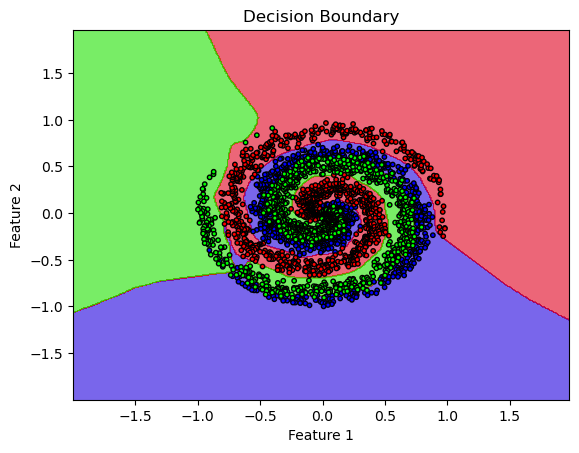

In [25]:
import matplotlib.pyplot as plt

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
predictions = model.forward(grid_points, training=False)
Z = np.argmax(predictions, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='brg', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=10, edgecolors='k')
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
